In [1]:
! cp /content/drive/MyDrive/final_dataset.zip final_dataset.zip
! mkdir output
! unzip final_dataset.zip -d output

Archive:  final_dataset.zip
   creating: output/final_dataset/training/
   creating: output/final_dataset/training/front/
  inflating: output/final_dataset/training/front/10.jpg  
  inflating: output/final_dataset/training/front/100.jpg  
  inflating: output/final_dataset/training/front/101.jpg  
  inflating: output/final_dataset/training/front/103.jpg  
  inflating: output/final_dataset/training/front/104.jpg  
  inflating: output/final_dataset/training/front/108.jpg  
  inflating: output/final_dataset/training/front/109.jpg  
  inflating: output/final_dataset/training/front/110.jpg  
  inflating: output/final_dataset/training/front/112.jpg  
  inflating: output/final_dataset/training/front/113.jpg  
  inflating: output/final_dataset/training/front/114.jpg  
  inflating: output/final_dataset/training/front/115.jpg  
  inflating: output/final_dataset/training/front/116.jpg  
  inflating: output/final_dataset/training/front/118.jpg  
  inflating: output/final_dataset/training/front/119.

In [2]:
from pathlib import Path
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [4]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [5]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "output/training"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), batch_size=BATCH_SIZE)

Found 754 images belonging to 2 classes.


In [6]:
train_steps = 754//BATCH_SIZE

In [7]:
VALID_DIR = "output/valid"
valid_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
#       rotation_range=90,
      horizontal_flip=True
#       vertical_flip=True
    )

valid_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
batch_size=BATCH_SIZE)

Found 90 images belonging to 2 classes.


In [8]:
valid_steps = 90//BATCH_SIZE

In [9]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # freeze the layers of the base model. We don't want to change the base feature extraction part
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    # we add our own classification part on top of the base model which is a combination of dense and dropout
    # followed by a softmax
    # the dense + dropout will add our own feature extraction which we can fine tune and classify
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [10]:
class_list = ['Front','Rear']

In [11]:
FC_LAYERS = [1024, 1024]
dropout = 0.5

HEIGHT = 300
WIDTH = 300

# we use resnet50 as the base model without the top (means it doesn't have a FC + softmax/classifier on top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, num_classes=len(class_list))

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
from keras.optimizers import SGD, Adam


BATCH_SIZE = 8
num_train_images = 500

adam = Adam(lr=0.0001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
NUM_EPOCHS = 5

In [14]:
history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=train_steps, 
                                       validation_data=valid_generator, validation_steps=valid_steps,
                                       shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
94/94 [==============================] - 16s 83ms/step - loss: 1.3506 - accuracy: 0.8888 - val_loss: 0.3449 - val_accuracy: 0.9773
Epoch 2/5
94/94 [==============================] - 7s 71ms/step - loss: 0.8932 - accuracy: 0.9689 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
94/94 [==============================] - 7s 70ms/step - loss: 0.3463 - accuracy: 0.9836 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
94/94 [==============================] - 7s 69ms/step - loss: 0.3071 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
94/94 [==============================] - 7s 71ms/step - loss: 0.1580 - accuracy: 0.9947 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


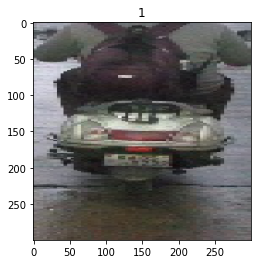

In [18]:
from keras.preprocessing import image
image_path="/content/output/training/rear/168.jpg" # output/train/Small/ground5999.png
img = image.load_img(image_path, target_size=(300,300))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=finetune_model.predict(img)
ch =int()
ch = 5
if(result[0][0] >result[0][1]):
  ch = 0
else:
  ch = 1
plt.title(ch)
plt.show()

In [19]:
import os
ext = "output//training//rear//"
files = os.listdir(ext)
numms = list()
for file in files:
  file = ext+file
  img = image.load_img(file, target_size=(300,300))
  img = np.expand_dims(img, axis=0)
  result=finetune_model.predict(img)
  if (result[0][0] >result[0][1]):
    ch = 0
  else:
    ch= 1
  numms.append(ch)

print(numms)






[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [17]:
finetune_model.load_weights('/content/drive/MyDrive/Front_rear_classifier.hd5')